# Recommender Systems

This notebook serves the following purposes - 
1. It acts as a tutorial for anyone wishing to get a deep dive into Recommendation algorithms.
2. Contrats between various techniques that are popularly used for Recommender Systems.
3. Briefly discuss on the various evaluation metrics for Recommender Systems.

The techniques that will be discussed are - 
1. Collaborative Filtering: User-User based.
2. Collaborative Filtering: Item-Item based.
3. Latent Factor Method: SVD.

I will be using the Amazon Product Reviews dataset in order to perform this comparison.

In [1]:
# Imports
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import BallTree

In [2]:
dataset = pd.read_csv('../input/amazon-ratings/ratings_Beauty.csv')

In [3]:
print(dataset.info())
dataset.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
UserId       object
ProductId    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB
None


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800


The dataset has 4 columns - UserID, ProductID, Rating and the Timestamp of rating. For the initial systems, we would be ignoring the Timestamp data. From this dataset, we would be creating a User-Item-Rating matrix. In order to test it in acceptable time, we will be using only 25000 rows of the data.

The first technique that we will follow is Collaborative Filtering using User similarity. We will use two similarity metric - Euclidean distance and Cosine similarity. Let's then analyze how the two fare against each other.

## Memory Based Collaborative Filtering

In [4]:
class Recommender:
    def __init__(self, strategy = 'user', neighbours = 10):
        self.strategy = strategy
        self.num_neighbours = neighbours
        if strategy is 'user':
            self.columns = ['User_' + str(index) for index in range(1, self.num_neighbours + 1)]
        elif strategy is 'item':
            self.columns = ['Item_' + str(index) for index in range(1, self.num_neighbours + 1)]
        
    def fit(self, matrix):
        if self.strategy is 'user':
            # User - User based collaborative filtering
            start_time = time.time()
            self.user_item_matrix = matrix
            self.mapper_indices = matrix.index
            self.user_tree = BallTree(matrix, leaf_size = self.num_neighbours * 2)
            time_taken = time.time() - start_time
            print('Model built in {} seconds'.format(time_taken))
            return self
        
        elif self.strategy is 'item':
            # Item - Item based collaborative filtering
            start_time = time.time()
            matrix = matrix.T
            self.item_user_matrix = matrix
            self.mapper_indices = matrix.index
            self.item_tree = BallTree(matrix, leaf_size = self.num_neighbours * 2)
            time_taken = time.time() - start_time
            print('Model built in {} seconds'.format(time_taken))
            return self
            
                    
    def predict(self, X_test):
        if self.strategy is 'user':
            y_pred = pd.Series(index = X_test.index)
            
            for index in tqdm(X_test.index, desc = 'Predicting Ratings'):
                row = X_test.loc[index]
                target_user = row['UserId']
                target_product = row['ProductId']
                
                if target_user not in self.user_item_matrix.index:
                    y_pred[index] = 0
                    continue
                
                user_attributes = self.user_item_matrix.loc[target_user]
                _, neighbour_indices = self.user_tree.query(user_attributes.values.reshape(1, -1), k = self.num_neighbours)
                
                rating = 0
                for neighbour_index in neighbour_indices:
                    user = self.mapper_indices[neighbour_index]
                    if target_product in self.user_item_matrix.loc[user].index:
                        rating += self.user_item_matrix.loc[user, target_product]
                    else:
                        rating += 0
                avg_rating = rating/self.num_neighbours
                y_pred.loc[index] = avg_rating
                
            return y_pred.values
        
        elif self.strategy is 'item':
            y_pred = pd.Series(index = X_test.index)
            
            for index in tqdm(X_test.index, desc = 'Predicting Ratings'):
                row = X_test.loc[index]
                target_user = row['UserId']
                target_product = row['ProductId']
                
                if target_product not in self.item_user_matrix.index:
                    y_pred[index] = 0
                    continue
                
                item_attributes = self.item_user_matrix.loc[target_product]
                _, neighbour_indices = self.item_tree.query(item_attributes.values.reshape(1, -1), k = self.num_neighbours)
                
                rating = 0
                for neighbour_index in neighbour_indices:
                    product = self.mapper_indices[neighbour_index]
                    if target_user in self.item_user_matrix.loc[product].index:
                        rating += self.item_user_matrix.loc[product, target_user]
                    else:
                        rating += 0
                avg_rating = rating/self.num_neighbours
                y_pred.loc[index] = avg_rating
                
            return y_pred.values
        
    def recommend_items(self, id, num_recommendations = 10):
        if self.strategy is 'user':
            user_id = id
            
            if user_id not in self.user_item_matrix.index:
                # New user - We will be looking at this case later on
                return None
            
            user_attributes = self.user_item_matrix.loc[user_id]
            distances, neighbour_indices = self.user_tree.query(user_attributes.values.reshape(1, -1), k = self.num_neighbours + 1)
            distances = distances[0]
            neighbour_indices = neighbour_indices[0]
            
            # We will be scoring each product by the user's distance from the target user and the 
            # rating given by the user to the item.
            recommendations = pd.DataFrame(columns = ['ProductId', 'Recommendability'])
            
            for index, neighbour_index in enumerate(neighbour_indices):
                user = self.mapper_indices[neighbour_index]
                user_similarity = 1 - distances[index]
                products_with_ratings = self.user_item_matrix.loc[user]
                
                for product_id in products_with_ratings.index:
                    recommendability = user_similarity * products_with_ratings.loc[product_id]
                    recommendation = {'ProductId': product_id, 'Recommendability': recommendability}
                    recommendations = recommendations.append(recommendation, ignore_index = True)
            
            recommendations.sort_values(by = 'Recommendability', ascending = False, inplace = True)
            recommendations = recommendations[~recommendations.duplicated('ProductId')]
            
            max_recommendations = min(num_recommendations, recommendations.shape[0])
            return recommendations.iloc[:max_recommendations, :-1]
        
        elif self.strategy is 'item':
            product_id = id
            
            if product_id not in self.item_user_matrix.index:
                # New product - We will be looking at this case later on
                return None
            
            product_attributes = self.item_user_matrix.loc[product_id]
            distances, neighbour_indices = self.item_tree.query(product_attributes.values.reshape(1, -1), k = num_recommendations)
            distances = distances[0]
            neighbour_indices = neighbour_indices[0]
            
            recommendations = pd.DataFrame(columns = ['ProductId', 'Recommendability'])
            
            for index, neighbour_index in enumerate(neighbour_indices):
                product_id = self.mapper_indices[neighbour_index]
                product_similarity = 1 - distances[index]
                
                recommendation = {'ProductId': product_id, 'Recommendability': product_similarity}
                recommendations = recommendations.append(recommendation, ignore_index = True)
            
            recommendations.sort_values(by = 'Recommendability', ascending = False, inplace = True)
            
            return recommendations.iloc[1:, :-1]

I will be checking the predicting ability of both __User - User__ & __Item - Item__ based Collaborative Filtering at first. For that I would take those products which are rated an appreciable number of times (atleast 500 ratings).

#### Objectives - 
- Check the effect of replacing NaN values with mean, with mode, with median and with 0.
- Check which method gives best result for newly added users/items, and how do you apply them!

In [5]:
# Let's look at the ratings count of the products
gb_product = dataset.groupby('ProductId').size()
gb_product = gb_product.sort_values()

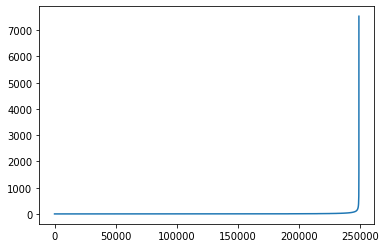

174


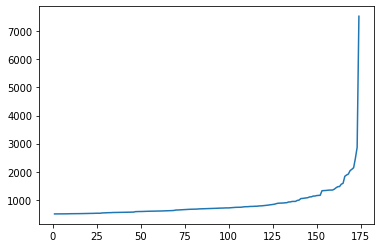

In [6]:
plt.plot(range(1, gb_product.shape[0] + 1), gb_product.values)
plt.show()
high_rated_products = gb_product[gb_product >= 500]
plt.plot(range(1, high_rated_products.shape[0] + 1), high_rated_products.values)
print(high_rated_products.shape[0])

We can see that there are a total of 174 products that are rated above 500 times. In order to see good results, we will focus on these products only.

In [7]:
data_complete = dataset.loc[dataset['ProductId'].isin(high_rated_products.index)]
data = data_complete.iloc[:, :-1]

In [8]:
data_train, data_test, _, _ = train_test_split(data, np.zeros(data.shape[0]), test_size = 0.2)

In [9]:
user_item_matrix_raw = pd.pivot_table(data_train, index = 'UserId', 
                                  columns = 'ProductId', values = 'Rating', aggfunc = np.sum)

In [10]:
print(user_item_matrix_raw.shape)
user_item_matrix_raw.head(4)

(109585, 174)


ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00262022JQPXX5SXEVJR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00275441WYR3489IKNAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00463203QYS5I5X6MMXW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The training data has ~1 lakh users and 174 products. Let's look at the sparsity of the User-Item matrix.

In [11]:
sparsity = np.isnan(user_item_matrix_raw.values).sum()/np.prod(user_item_matrix_raw.shape)
print('The sparsity of the matrix is: {}'.format(sparsity))

The sparsity of the matrix is: 0.9937748422863898


This means that only 0.067% of the matrix has values.

In [12]:
# Filling the NaN values with mean of the column
user_item_matrix = user_item_matrix_raw.fillna(user_item_matrix_raw.mean())
user_item_matrix.head(4)

ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,4.62069,3.493671,4.087248,3.985455,4.362369,4.606818,4.340336,4.411559,3.711268,3.558621,...,4.007491,4.607656,4.655702,4.425056,3.708831,4.444181,4.585,4.376712,4.454161,4.113014
A00262022JQPXX5SXEVJR,4.62069,3.493671,4.087248,3.985455,4.362369,4.606818,4.340336,4.411559,3.711268,3.558621,...,4.007491,4.607656,4.655702,4.425056,3.708831,4.444181,4.585,4.376712,4.454161,4.113014
A00275441WYR3489IKNAB,4.62069,3.493671,4.087248,3.985455,4.362369,4.606818,4.340336,4.411559,3.711268,3.558621,...,4.007491,4.607656,4.655702,4.425056,3.708831,4.444181,4.585,4.376712,4.454161,4.113014
A00463203QYS5I5X6MMXW,4.62069,3.493671,4.087248,3.985455,4.362369,4.606818,4.340336,4.411559,3.711268,3.558621,...,4.007491,4.607656,4.655702,4.425056,3.708831,4.444181,4.585,4.376712,4.454161,4.113014


We will be following two ways to build the recommender system - Directly using the ratings given in the dataset, and Assuming that the ratings given can be broken down into chunks of interpretable sections. An example would be - 
Rating = Baseline Rating + User-Product-Interaction.

Have you ever noticed, users usually tend to give an average rating of 3 to almost every product they buy. Visualize this by imagining viewing a product with rating 1 - Would you call it as being a bit good, or, maybe the product is very bad, hence it has a __bad__ rating!

This baseline rating is a term which can be removed from each and every rating, to accurately understand the relationship between user and the product.

Along with these two strategies, we would also be using two metrics - Similarity index and Euclidean distance.

In [13]:
user_item_matrix_rating = user_item_matrix.apply(lambda row: row - 3)

## User - User CF

In [14]:
recommender = Recommender().fit(user_item_matrix)

Model built in 33.9762749671936 seconds


In [15]:
recommender_rating = Recommender().fit(user_item_matrix_rating)

Model built in 36.18389916419983 seconds


One very important observation is that using a Ball-Tree structure reduces training time significantly. Using a brute for KNN would take a hell lot more time for training these many samples.

The brute force KNN that I was using previously took 7 minutes to train on just 3200 user ids, when it was run parallely on 6 CPU cores with a batch size of 100. While this version, using KD Tree, trains on a sample of 100,000 in just ~30 seconds.

In [16]:
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

In [17]:
# Predicting using the two recommender models for normal as well as overhead rating 
y_pred = recommender.predict(X_test)
y_pred_rating = recommender_rating.predict(X_test)

y_pred_rating += 3

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_rating = np.sqrt(mean_squared_error(y_test, y_pred_rating))

print('RMSE using first perscpective: {}\nRMSE using second perspective: {}'.format(rmse, rmse_rating))

Predicting Ratings: 100%|██████████| 29676/29676 [02:44<00:00, 179.97it/s]

RMSE using first perscpective: 4.372067596003612
RMSE using second perspective: 1.7305715864722582


Observation - The root mean square in predictions drastically reduce with the hypothesis we assumed.

The predictions are also done in a very impressive time - ~2 minutes for ~30000 user ids

Using the rating that is devoid of baseline rating does seem to give better results than the plain simple system. There are a very important deduction from these experimental results - 

- It is better to predict the overhead rating (by ignoring the baseline rating), and then add the baseline rating. This means that hypothesis: "People usually tend to rate some product at a baseline level (3 here) unless the product experience with the user is very bad" is a better start off point for a Recommender system.

The second perspective is definitely better in producing results. But how can it be improved? Can there be a third segment in the rating? Yes, definitely!

Intuition - Have you experienced yourself rating drivers of a particular application (Uber, in my case) more generously/harshly day by day? This is the third aspect in rating - a general user experience with the application. In the context of movies, you can imagine this as you being a harsher critic day by day. This kind of interaction (user - service) can be modelled using the timestamp provided. We will look at such interactions closely in later part of this notebook.

In general - 
$$Rating = Baseline Rating + User Service Interaction Rating + User Product Interaction Rating$$

## Item - Item CF

In [18]:
recommender_item = Recommender(strategy = 'item').fit(user_item_matrix)

Model built in 1.0039796829223633 seconds


In [19]:
recommender_item_rating = Recommender(strategy = 'item').fit(user_item_matrix_rating)

Model built in 1.0067930221557617 seconds


In [20]:
# Predicting using the two recommender models for normal as well as overhead rating 
y_item_pred = recommender_item.predict(X_test)
y_item_pred_rating = recommender_item_rating.predict(X_test)

y_item_pred_rating += 3

rmse = np.sqrt(mean_squared_error(y_test, y_item_pred))
rmse_rating = np.sqrt(mean_squared_error(y_test, y_item_pred_rating))

print('RMSE using first perscpective: {}\nRMSE using second perspective: {}'.format(rmse, rmse_rating))

Predicting Ratings: 100%|██████████| 29676/29676 [14:42<00:00, 33.62it/s]

RMSE using first perscpective: 4.372067596003612
RMSE using second perspective: 1.7305715864722582


Just as the observation in User - User based CF, we can see that the RMSE figures drop when we assume the baseline rating hypothesis. However, one contrasting feature that can be found here is that there is some difference between Cosine and Euclidean metric.

Now that we have built models and seen how they perform in various scenarios, let's see how they recommend stuff!

## Recommendations

This is the important and the most interesting part of building Recommender Systems - recommending products for the users. Let's see how the four models above perform!

We will be using the User ID - ABQAIIBTTEKVM, and Product ID - B004OHQR1Q in order to compare the results.

### User - User CF Recommendations

In [21]:
recommender.recommend_items('ABQAIIBTTEKVM')

,ProductId
1371,B008U1Q4DI
632,B004TSFBNK
298,B005UBN5AQ
1533,B007Q0WW0S
862,B00CNOUZE2
906,B000ODNSR0
1311,B003UH0528
1524,B006IBM21K
1476,B003BQ6QXK
1740,B00004TUBL


In [22]:
recommender_rating.recommend_items('ABQAIIBTTEKVM')

,ProductId
1371,B008U1Q4DI
632,B004TSFBNK
298,B005UBN5AQ
1533,B007Q0WW0S
862,B00CNOUZE2
906,B000ODNSR0
1311,B003UH0528
1524,B006IBM21K
1476,B003BQ6QXK
1740,B00004TUBL


### Item - Item CF Recommendations

In [23]:
recommender_item.recommend_items('B004OHQR1Q')

,ProductId
1,B00D6EDGYE
2,B00I073WLE
3,B000OQ2DL4
4,B001TJXI5U
5,B00FAEOCP0
6,B008O4YM4Y
7,B0002Z8HAI
8,B005Y6F4WO
9,B002TPQPEE


In [24]:
recommender_item_rating.recommend_items('B004OHQR1Q')

,ProductId
1,B00D6EDGYE
2,B00I073WLE
3,B000OQ2DL4
4,B001TJXI5U
5,B00FAEOCP0
6,B008O4YM4Y
7,B0002Z8HAI
8,B005Y6F4WO
9,B002TPQPEE


#### Explanation of the results.

There are two aspects in this explanation - explaining the difference between the RMSE values for the two perspectives, and getting the same set of recommendations inspite of the difference is predicted ratings.

1. The reason for observing the difference in RMSE is that a value of 0 is predicted for items which the user has not rated (Item - Item CF) or the similar users who have not rated the item (User - User CF). If we interpret this value of 0 that is predicted, it can be understood that it has two meanings in the two perspectives. In the first perspective, where the ratings are kept between 0 and 5, a rating of 0 means that the user has absolutely disliked the product (on a relative scale). However, in the latter perspective, a rating of 0 implies that user has an average view of the product. If you try to imagine the situation, it would be similar to - first perspective says that a user who has not seen this product will absolutely dislike it, and second perspective says that the user would give it a baseline rating.
    Looking at it this way clearly shows that the perspectives are actually similar, if we rate 3 for a product unseen by the user in context.
    
2. The reason for outputting same recommendations for both the perspective is that - Euclidean distance (used for finding neighbours in KDTree or BallTree) is invariant under a Translation Transformation (deducting the baseline transformation is essentially a translation of the points by 3 units). Hence, the neighbour still remain the same, which leads to the same recommendations being generated [all the time].

### Varying statistic for NaN values

From the above explanation, it is pretty clear that using a baseline rating for unintroduced User-Item pair is quite beneficial. Hence, instead of using mean as the filler for 'NaN' values, it would be better to use the baseline rating. It would not introduce any unwanted bias.

Going forward, I would be using only the second perspective, as it is already established that the two are similar and just differ in ratings they output for unintroduced User-Item pair.

In [25]:
user_item_matrix_baseline = user_item_matrix_raw.fillna(3) - 3
user_item_matrix_baseline.head(4)

ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00262022JQPXX5SXEVJR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00275441WYR3489IKNAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00463203QYS5I5X6MMXW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
recommender_baseline = Recommender().fit(user_item_matrix_baseline)

Model built in 28.88993740081787 seconds


In [27]:
y_pred_baseline = recommender_baseline.predict(X_test)
y_pred_baseline += 3

rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print('RMSE using User-User CF: {}'.format(rmse_baseline))

Predicting Ratings: 100%|██████████| 29676/29676 [02:28<00:00, 200.05it/s]

RMSE using User-User CF: 1.7305715864722582


In [28]:
recommender_item_baseline = Recommender(strategy = 'item').fit(user_item_matrix_baseline)

Model built in 1.0840580463409424 seconds


In [29]:
y_pred_item_baseline = recommender_item_baseline.predict(X_test)
y_pred_item_baseline += 3

rmse_item_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print('RMSE using Item-Item CF: {}'.format(rmse_item_baseline))

Predicting Ratings: 100%|██████████| 29676/29676 [19:17<00:00, 25.64it/s]

RMSE using Item-Item CF: 1.7305715864722582


The observation is that RMSE value doesn't change! Using the baseline rating is much more logical than using the mean value. More strategies for dealing with missing values would be dealt with while discussing Latent Factor Methods.

## Model based Collaborative Filtering

The most prominent type of model based collaborative filtering is Latent Matrix Factorization. Usually SVD is used to factorize the user-item matrix into two matrices of user-embeddings and embeddings-item.

But what do embeddings mean? Well these are latent features that are obtained after factorization. For a User-Movie dataset, you can assume embbedings to be - a. How sci-fi the movie is? b. how recent is the movie? etc.

These are not the actual factors that are generated, infact no one knows the interpretation of the embeddings - precisely why the word Latent is used.

I will be using the Surprise library in order to implement the SVD to obtain the Latent Factor Matrices.

In [30]:
class ModelRecommender:
    def __init__(self, strategy = 'SVD', latent_factors = 5, num_epochs = 10, reg_param = 0.01):
        self.strategy = strategy
        self.latent_factors = latent_factors = 5
        self.num_epochs = 10
        self.reg_param = reg_param
        self.learning_rate = 0.0005
        
    def fit(self, matrix):
        m, n = matrix.shape
        self.P = pd.DataFrame(np.random.rand(m, self.latent_factors), index = matrix.index) # Users
        self.Q = pd.DataFrame(np.random.rand(n, self.latent_factors), index = matrix.columns) # Products
        
        users = list(matrix.index)
        products = list(matrix.columns)

        for epoch in tqdm(range(self.num_epochs), desc = 'Epoch'):
            for user, product in zip(users, products):
                error = matrix.loc[user, product] - self.predictions(self.P.loc[user].values, self.Q.loc[product].values)
                self.P.loc[user] += self.learning_rate * (error * self.Q.loc[product].values - self.reg_param * self.P.loc[user].values)
                self.Q.loc[product] += self.learning_rate * (error * self.P.loc[user].values - self.reg_param * self.Q.loc[product].values)
                
    def predictions(self, P, Q):
        return np.dot(P, Q.T)
    
    def predict(self, X_test):
        y_pred = pd.Series(index = X_test.index)
        
        for index, row in X_test.iterrows():
            user_id = row['UserId']
            product_id = row['ProductId']
            if user_id not in self.P.index:
                y_pred.loc[index] = 0
                continue
            if product_id not in self.Q.index:
                y_pred.loc[index] = 0
                continue
            pred = self.predictions(self.P.loc[user_id].values, self.Q.loc[product_id].values)
            y_pred.loc[index] = pred
        
        return y_pred.values
    
    def recommend(self, user_id, num_recommendations = 10):
        recommendations = pd.DataFrame(columns = ['ProductId', 'Recommendability'])
        
        for product_id in self.Q.index:
            recommendability = self.predictions(self.P.loc[user_id].values, self.Q.loc[product_id].values)
            recommendations = recommendations.append({'ProductId': product_id, 'Recommendability': recommendability}, ignore_index = True)
            
        recommendations.sort_values(by = 'Recommendability', ascending = False, inplace = True)
        
        max_recommendations = min(num_recommendations, self.Q.shape[0])
        return recommendations.iloc[:max_recommendations, 0]

In [31]:
# Filling NaN values with baseline rating
user_item_matrix = user_item_matrix_raw.fillna(3)
user_item_matrix.head(4)

ProductId,B00004TUBL,B0000530ED,B00005O0MZ,B0000632EN,B00006IV2F,B0000AFUTL,B0000CC64W,B0000YUXI0,B0000ZLEFU,B00011QUDE,...,B00C7DYBX0,B00CFRBIC0,B00CNOUZE2,B00D6EDGYE,B00E68O4JU,B00FAEOCP0,B00GFBWWWC,B00GP184WO,B00I073WLE,B00IALDHDI
UserId,,,,,,,,,,,,,,,,,,,,,
A00120381FL204MYH7G3B,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
A00262022JQPXX5SXEVJR,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
A00275441WYR3489IKNAB,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
A00463203QYS5I5X6MMXW,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [32]:
user_item_matrix_rating = user_item_matrix - 3

### Normal Rating

In [33]:
recommender = ModelRecommender()
recommender.fit(user_item_matrix)

Epoch: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


In [34]:
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

In [35]:
y_pred = recommender.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE using normal rating method: {}'.format(rmse))

RMSE using normal rating method: 4.234016963300366


### Baseline Rating

In [36]:
recommender_rating = ModelRecommender()
recommender_rating.fit(user_item_matrix_rating)

Epoch: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


In [37]:
y_pred_rating = recommender.predict(X_test)
y_pred_rating += 3
rmse_rating = np.sqrt(mean_squared_error(y_test, y_pred_rating))

print('RMSE using baseline rating method: {}'.format(rmse_rating))

RMSE using baseline rating method: 1.6745994975150658


There is a very slight increase in the performance of the model in terms of predictions. What is noticeable that it has achieved this much performance in almost negligible time, as compared to the previous methods.

Let's look at the recommendations provided by the method.

In [38]:
recommender.recommend('ABQAIIBTTEKVM', 10)

4      B00006IV2F
157    B009GIOVKC
116    B00538TSMU
47     B000UPRSKA
41     B000PY17PI
105    B004FEKA3E
91     B003QKL5YQ
3      B0000632EN
160    B009RNUH4A
156    B009GEUPDS
Name: ProductId, dtype: object

In [39]:
recommender_rating.recommend('ABQAIIBTTEKVM', 10)

152    B008U12YV4
64     B001BALMCS
117    B0056GDG90
167    B00D6EDGYE
37     B000OQ2DL4
141    B007Q0WW0S
132    B006IBM21K
63     B001AO0WCG
106    B004GQZX4M
107    B004INUWX0
Name: ProductId, dtype: object

Here, we can see that not only the results are different for the two perspectives, but also different from the ones predicted by User - User and Item - Item based recommendations. 

Although, I can't comment on the qualitative aspect of the recommendation, however, I am inclined to say that these predictions would be better (Please pardon my biasness).